Imports et config

In [2]:
import pandas as pd
import numpy as np
import sqlalchemy as sql
import configparser
import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import io
import boto3
import json

config = configparser.ConfigParser()
config.read('../config/default.ini')
engine = sql.create_engine('postgresql://{}:{}@{}:{}/{}'.format(config['DATABASE']['username'], config['DATABASE']['password'].replace('_percentage_', '%'), config['DATABASE']['host'], config['DATABASE']['port'], config['DATABASE']['database']),pool_recycle=600)

# Egos First Steps
Ce notebook essaye de faire une première incursion dans les données du datawarehouse (redshift) qui contiennent les données trackers, utilisateurs, catalogue, entre autres.

Il y a quelques exemples illustratifs pour accéder à certaines tables, mais je vous invite à naviguer plus en profondeur dans toutes les tables existant pour satisfaire vos besoins.

Le projet [`egos-data-environment`](https://gitlab.com/bigdata-media/egos-data-environment) contient la documentation de certaines tables dans l'environnement EGOS.

![](https://gitlab.com/mvanegas10/data-access-app/-/raw/master/notebook/input/200528_schema_egos.svg)

## Données

### Données trackers 
Accessibles à partir de datawarehouse -> *Merci Aymen !*
```sql
SELECT *
FROM datawarehouse.egos_fct_trackers
LIMIT 1
```

In [2]:
df = pd.read_sql_query("""
    SELECT *
    FROM datawarehouse.egos_fct_trackers
    LIMIT 1""", engine)
df.transpose()

0
fk_dvc               10
fk_media         269748
fk_date              28
fk_plt                4
fk_sid        234557708
fk_uag          5340238
fk_mediatype         10
fk_uid        168329511
fk_idplayer      255168
fk_type              10
navigation         1504
current_t          1328
total_t            1659
pagevues              1

### Juste des chiffres, ça ne veut rien dire ! ... une petite rappel du schema étoile :
Table de fait, dimensions et messures 
![Schema Fact Table](https://gitlab.com/mvanegas10/data-access-app/-/raw/master/notebook/input/fact_table.png)

### *Plus claire:* Prenons les dimensions en faisant la jointure
```sql
SELECT device, mediaid, date, platform, useragent, mediatype, uid, navigation, current_t, total_t, pagevues
FROM datawarehouse.egos_fct_trackers trk
    INNER JOIN datawarehouse.egos_tracker_dim_device dvc ON trk.fk_dvc = dvc.pk_dvc
    INNER JOIN datawarehouse.egos_tracker_dim_media media ON trk.fk_media = media.pk_media
    INNER JOIN datawarehouse.egos_tracker_dim_date date ON trk.fk_date = date.pk_date
    INNER JOIN datawarehouse.egos_tracker_dim_platform plt ON trk.fk_plt = plt.pk_plt
    INNER JOIN datawarehouse.egos_tracker_dim_useragent uag ON trk.fk_uag = uag.pk_uag
    INNER JOIN datawarehouse.egos_tracker_dim_mediatype mediatype ON trk.fk_mediatype = mediatype.pk_mediatype
    INNER JOIN datawarehouse.egos_tracker_dim_users uid ON trk.fk_uid = uid.pk_uid
LIMIT 1
```

In [3]:
df = pd.read_sql_query("""
    SELECT device, mediaid, date, platform, useragent, mediatype, uid, navigation, current_t, total_t, pagevues
    FROM datawarehouse.egos_fct_trackers trk
        INNER JOIN datawarehouse.egos_tracker_dim_device dvc ON trk.fk_dvc = dvc.pk_dvc
        INNER JOIN datawarehouse.egos_tracker_dim_media media ON trk.fk_media = media.pk_media
        INNER JOIN datawarehouse.egos_tracker_dim_date date ON trk.fk_date = date.pk_date
        INNER JOIN datawarehouse.egos_tracker_dim_platform plt ON trk.fk_plt = plt.pk_plt
        INNER JOIN datawarehouse.egos_tracker_dim_useragent uag ON trk.fk_uag = uag.pk_uag
        INNER JOIN datawarehouse.egos_tracker_dim_mediatype mediatype ON trk.fk_mediatype = mediatype.pk_mediatype
        INNER JOIN datawarehouse.egos_tracker_dim_users uid ON trk.fk_uid = uid.pk_uid
    LIMIT 1""", engine)
df.transpose()

0
device                                                 mobile
mediaid                                               2737128
date                                      2021-02-20 00:00:00
platform                                              android
useragent   Auvio/2.0.5 (be.rtbf.auvio; build:238; type:mo...
mediatype                                               video
uid                          5018742b6f224ea28b5f0864f9bbb8d7
navigation                                               6261
current_t                                                2568
total_t                                                  5142
pagevues                                                    1

### Regardons quelques chifres... 
**Consommation par type de média par semaine :**
```sql
SELECT DATE_TRUNC('week', date) AS week, mediatype, COUNT(DISTINCT uid)
FROM datawarehouse.egos_fct_trackers trk
    INNER JOIN datawarehouse.egos_tracker_dim_date date ON trk.fk_date = date.pk_date
    INNER JOIN datawarehouse.egos_tracker_dim_mediatype mediatype ON trk.fk_mediatype = mediatype.pk_mediatype
    INNER JOIN datawarehouse.egos_tracker_dim_users uid ON trk.fk_uid = uid.pk_uid
WHERE mediatype IN ('audio','video','article','live')
GROUP BY week, mediatype
ORDER BY week
```

In [4]:
df = pd.read_sql_query("""
    SELECT DATE_TRUNC('week', date) AS week, typeplayers, mediatype, COUNT(DISTINCT uid)
    FROM datawarehouse.egos_fct_trackers trk
        INNER JOIN datawarehouse.egos_tracker_dim_date date ON trk.fk_date = date.pk_date
        INNER JOIN datawarehouse.egos_tracker_dim_typeplayers typeplayer ON trk.fk_type = typeplayer.pk_type
        INNER JOIN datawarehouse.egos_tracker_dim_mediatype mediatype ON trk.fk_mediatype = mediatype.pk_mediatype
        INNER JOIN datawarehouse.egos_tracker_dim_users uid ON trk.fk_uid = uid.pk_uid
    WHERE mediatype IN ('audio','video','article','live')
    GROUP BY typeplayers, week, mediatype
    ORDER BY week""", engine)
df.head()

week typeplayers mediatype    count
0 2018-12-31       undef   article  1332783
1 2018-12-31       audio     audio     5474
2 2018-12-31       audio   article     7077
3 2018-12-31       video   article   113556
4 2018-12-31        live   article     1005

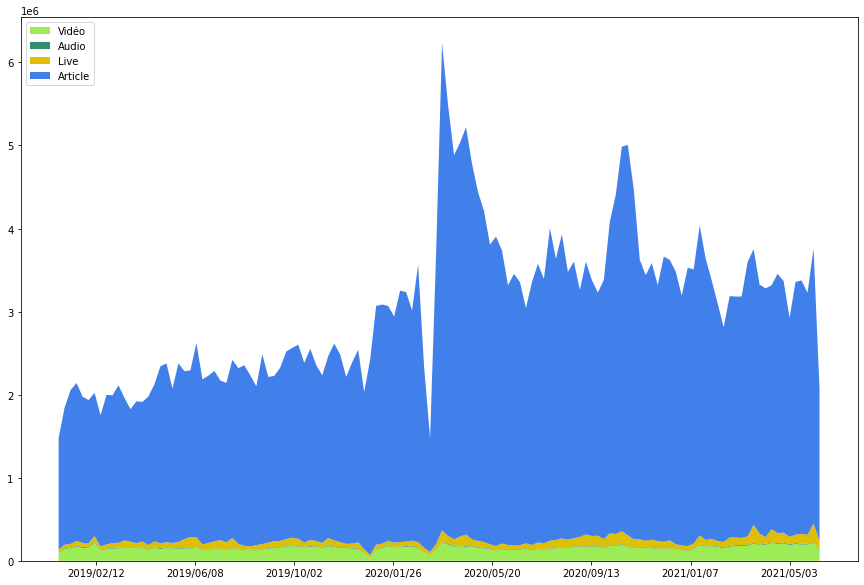

In [5]:
days = df['week'].apply(lambda x: int(x.timestamp())).unique()
plt.figure(figsize = (15,10))
plt.stackplot(days, 
              df[df.mediatype == 'video']['count'],
              df[df.mediatype == 'audio']['count'],
              df[df.mediatype == 'live']['count'],
              df[df.mediatype == 'article']['count'],
              labels=['Vidéo','Audio','Live', 'Article'],
              colors=('#9bec55', '#358d6b', '#dfbf05', '#4180eb'))
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_formatter(lambda x,y: datetime.datetime.fromtimestamp(x).strftime('%Y/%m/%d'))

### ATENTION ! Pour faire un comptage distinct d'utilisateurs il faut prendre que les utilisateurs connectés...
**Filtre important à savoir :** Comment reconnaitre un utilisateur connecté ? 
```sql
WHERE octet_length(uid) < 51 -- longeur d'uid inférieur à 51 (il y a des utilisateurs bizarres pê robots)
AND octet_length(uid) != 36 -- longeur d'uid différent à 36 (== à 36 sont d'utilisateurs non connectés)
AND uid != 'Private'
AND uid != 'anonymous'  
```

In [26]:
df = pd.read_sql_query("""
    SELECT DATE_TRUNC('week', date) AS week, mediatype, COUNT(DISTINCT uid)
    FROM datawarehouse.egos_fct_trackers trk
        INNER JOIN datawarehouse.egos_tracker_dim_date date ON trk.fk_date = date.pk_date
        INNER JOIN datawarehouse.egos_tracker_dim_mediatype mediatype ON trk.fk_mediatype = mediatype.pk_mediatype
        INNER JOIN datawarehouse.egos_tracker_dim_users uid ON trk.fk_uid = uid.pk_uid
    WHERE mediatype IN ('audio','video','article','live') AND
        octet_length(uid) < 51
        and octet_length(uid) != 36
        and uid != 'Private'
        and uid != 'anonymous'    
    GROUP BY week, mediatype
    ORDER BY week""", engine)
df.head()

x        g    count
0   2018-12-31  article  1340751
2   2019-06-24  article  2015106
3   2019-12-09  article  2183789
4   2020-06-22  article  3166464
5   2020-10-26  article  4699933
..         ...      ...      ...
651 2021-05-10    audio     9613
652 2019-04-08    audio     7787
653 2021-03-29    audio     7683
654 2020-07-06    audio     6459
655 2019-10-07    audio     6964

[508 rows x 3 columns]

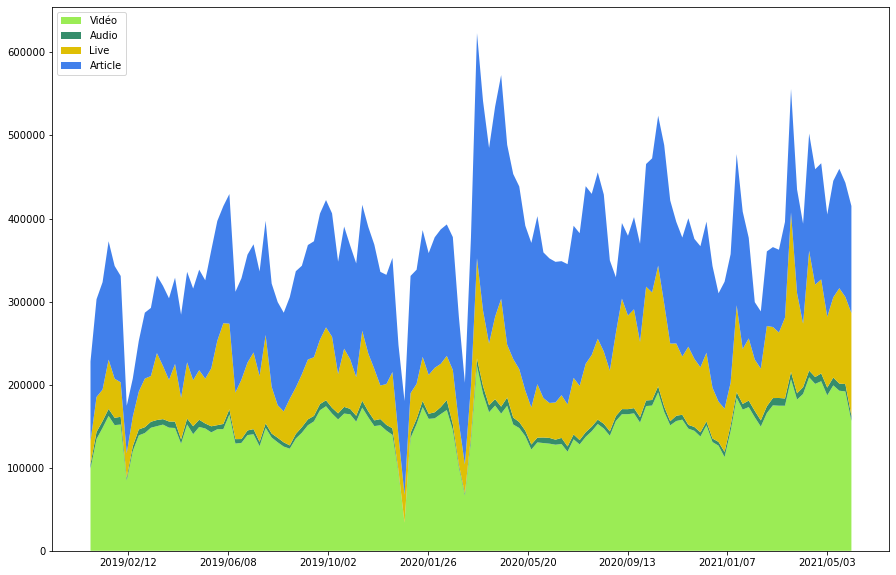

In [70]:
days = df['week'].apply(lambda x: int(x.timestamp())).unique()
plt.figure(figsize = (15,10))
plt.stackplot(days, 
              df[df.mediatype == 'video']['count'],
              df[df.mediatype == 'audio']['count'],
              df[df.mediatype == 'live']['count'],
              df[df.mediatype == 'article']['count'],
              labels=['Vidéo','Audio','Live', 'Article'],
              colors=('#9bec55', '#358d6b', '#dfbf05', '#4180eb'))
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_formatter(lambda x,y: datetime.datetime.fromtimestamp(x).strftime('%Y/%m/%d'))

### Regardons notre consommation :)
Comment connaitre notre id utilisateur ?

![](https://gitlab.com/mvanegas10/data-access-app/-/raw/master/notebook/input/data_inputs.png)

### La table egos_gigya contient les profils RTBF
```sql
SELECT * 
FROM egos_gigya
WHERE email = 'mvhdez_18@hotmail.com'
```

In [13]:
df = pd.read_sql_query("""
    SELECT * 
    FROM egos_gigya
    WHERE email = 'mvhdez_18@hotmail.com'""", engine)
df.transpose()

0
uid                        6e4531b0671946199b14bca76abe45b0
age                                                      26
city                                                   None
gender                                                 None
hometown                                               None
languages                                              None
firstname                                             Meili
lastname                                            Vanegas
birthday                                                 12
birthmonth                                                6
birthyear                                              1994
zip                                                    1170
country                                                None
created                          2020-05-22 12:26:26.713000
registered                       2020-05-22 12:26:26.812000
verified                         2020-05-22 12:26:47.144000
lastupdated                      2021-06-02 10:01:46.210000
regsource                        https://www.rtbf.be/auvio/
referrer                         https://www.rtbf.be/auvio/
belgian                                               False
belgianverified                                        None
lastlogin                        2021-06-02 08:20:20.124000
email                                 mvhdez_18@hotmail.com
actitoid                                           39360594
number                                                 None
loginprovider                                          site
socialproviders                                        site
stripeid                                               None
lastprofileupdateforadobe                              None

In [14]:
uid = df.iloc[0]['uid']

La jointure avec le tracker se fait via le **uid** :
```sql
SELECT DATE_TRUNC('month', date) AS month, mediatype, COUNT(DISTINCT mediaid)
FROM datawarehouse.egos_fct_trackers trk
    INNER JOIN datawarehouse.egos_tracker_dim_date date ON trk.fk_date = date.pk_date
    INNER JOIN datawarehouse.egos_tracker_dim_device device ON trk.fk_dvc = device.pk_dvc
    INNER JOIN datawarehouse.egos_tracker_dim_media media ON trk.fk_media = media.pk_media
    INNER JOIN datawarehouse.egos_tracker_dim_mediatype mediatype ON trk.fk_mediatype = mediatype.pk_mediatype
    INNER JOIN datawarehouse.egos_tracker_dim_users uid ON trk.fk_uid = uid.pk_uid
WHERE 
    mediatype IN ('audio','video','article','live') AND
    uid = ?
GROUP BY month, mediatype
ORDER BY month
```

In [16]:
df = pd.read_sql_query("""
    SELECT DATE_TRUNC('month', date) AS month, mediatype, COUNT(DISTINCT mediaid)
    FROM datawarehouse.egos_fct_trackers trk
        INNER JOIN datawarehouse.egos_tracker_dim_date date ON trk.fk_date = date.pk_date
        INNER JOIN datawarehouse.egos_tracker_dim_device device ON trk.fk_dvc = device.pk_dvc
        INNER JOIN datawarehouse.egos_tracker_dim_media media ON trk.fk_media = media.pk_media
        INNER JOIN datawarehouse.egos_tracker_dim_mediatype mediatype ON trk.fk_mediatype = mediatype.pk_mediatype
        INNER JOIN datawarehouse.egos_tracker_dim_users uid ON trk.fk_uid = uid.pk_uid
    WHERE 
        mediatype IN ('audio','video','article','live') AND
        uid = '{}'
    GROUP BY month, mediatype
    ORDER BY month""".format(uid), engine)
df.head()

month mediatype  count
0 2020-05-01   article      1
1 2020-06-01   article      1
2 2020-06-01     video      4
3 2020-07-01   article     15
4 2020-08-01     video      1

In [17]:
days = df['month'].apply(lambda x: int(x.timestamp())).unique()
df_fig = df.pivot(index='month', columns=['mediatype'], values='count').reset_index()
empty = [0 for i in days]
plt.figure(figsize = (15,10))
plt.stackplot(days, 
              df_fig['article'] if 'article' in df_fig.columns else empty,
              df_fig['video'] if 'video' in df_fig.columns else empty,
              df_fig['live'] if 'live' in df_fig.columns else empty,
              df_fig['audio'] if 'audio' in df_fig.columns else empty,
              labels=['Article', 'Vidéo','Live','Audio'],
              colors=('#4180eb', '#9bec55', '#dfbf05', '#358d6b'))
plt.legend(loc='upper left')
plt.gca().xaxis.set_major_formatter(lambda x,y: datetime.datetime.fromtimestamp(x).strftime('%Y/%m/%d'))

### À quels segments appartenons-nous ?
La table qui contient les segments est `egos_user_segments`. Par contre, cette table a été développée pour l'exporter vers *ACTITO*, donc, l'utilisateur n'est pas identifié via l'*uid* mais via l'*actitoid*. Heureusement, nous pouvons trouver l'*actitoid* dans la table `egos_gigya`.

In [24]:
df = pd.read_sql_query("""
    SELECT seg.*
    FROM egos_user_segments seg 
        INNER JOIN egos_gigya gigya ON seg.actitoid = gigya.actitoid
    WHERE uid = '{}'
""".format(uid), engine)
df.transpose()

0                    1                    2   \
actitoid              39360594             39360594             39360594   
segment                    AB3                   TV               Tarmac   
last_date  2020-10-08 19:00:00  2021-06-02 12:00:00  2020-09-28 12:00:00   
recency          last_365_days          last_7_days        last_365_days   

                            3                    4                    5   \
actitoid              39360594             39360594             39360594   
segment                 Tennis                Films             Cyclisme   
last_date  2020-12-04 10:00:00  2021-05-21 10:00:00  2021-05-20 08:00:00   
recency          last_365_days         last_30_days         last_30_days   

                            6                    7                    8   \
actitoid              39360594             39360594             39360594   
segment              Knowledge              Culture            AuvioKids   
last_date  2021-05-20 10:00:00  2021-03-17 14:00:00  2021-04-29 12:00:00   
recency           last_30_days         last_90_days         last_90_days   

                            9   ...                   29                   30  \
actitoid              39360594  ...             39360594             39360594   
segment             SeriesNous  ...          Information              Fiction   
last_date  2021-04-27 10:00:00  ...  2021-06-02 12:00:00  2021-05-21 10:00:00   
recency           last_90_days  ...          last_7_days         last_30_days   

                            31                   32                   33  \
actitoid              39360594             39360594             39360594   
segment             Patrimoine                Sport         Consommation   
last_date  2021-02-19 11:00:00  2021-05-20 09:00:00  2021-01-11 10:00:00   
recency          last_180_days         last_30_days        last_180_days   

                            34                   35                   36  \
actitoid              39360594             39360594             39360594   
segment           EuropaLeague     MusiqueClassique           LaPremiere   
last_date  2021-05-20 09:00:00  2020-06-22 10:00:00  2021-05-20 10:00:00   
recency           last_30_days        last_365_days         last_30_days   

                            37                   38  
actitoid              39360594             39360594  
segment              Lifestyle          AuvioColors  
last_date  2021-05-20 09:00:00  2021-03-25 13:00:00  
recency           last_30_days         last_90_days  

[4 rows x 39 columns]

In [26]:
df = df.sort_values('last_date', ascending=False)
df.head(50)

actitoid           segment           last_date        recency
29  39360594       Information 2021-06-02 12:00:00    last_7_days
1   39360594                TV 2021-06-02 12:00:00    last_7_days
10  39360594          Football 2021-06-02 10:00:00    last_7_days
30  39360594           Fiction 2021-05-21 10:00:00   last_30_days
4   39360594             Films 2021-05-21 10:00:00   last_30_days
6   39360594         Knowledge 2021-05-20 10:00:00   last_30_days
24  39360594         Classic21 2021-05-20 10:00:00   last_30_days
36  39360594        LaPremiere 2021-05-20 10:00:00   last_30_days
15  39360594          Histoire 2021-05-20 10:00:00   last_30_days
17  39360594     Entertainment 2021-05-20 10:00:00   last_30_days
32  39360594             Sport 2021-05-20 09:00:00   last_30_days
34  39360594      EuropaLeague 2021-05-20 09:00:00   last_30_days
37  39360594         Lifestyle 2021-05-20 09:00:00   last_30_days
20  39360594          Vivacite 2021-05-20 08:00:00   last_30_days
5   39360594          Cyclisme 2021-05-20 08:00:00   last_30_days
27  39360594           Moteurs 2021-04-30 13:00:00   last_90_days
16  39360594            MotoGP 2021-04-30 13:00:00   last_90_days
28  39360594     Documentaires 2021-04-29 12:00:00   last_90_days
21  39360594           RelaxJA 2021-04-29 12:00:00   last_90_days
8   39360594         AuvioKids 2021-04-29 12:00:00   last_90_days
12  39360594           Cuisine 2021-04-29 12:00:00   last_90_days
9   39360594        SeriesNous 2021-04-27 10:00:00   last_90_days
18  39360594     Investigation 2021-04-20 15:00:00   last_90_days
11  39360594            Hockey 2021-04-13 15:00:00   last_90_days
23  39360594     DiablesRouges 2021-03-25 13:00:00   last_90_days
22  39360594      SeriesCorner 2021-03-25 13:00:00   last_90_days
38  39360594       AuvioColors 2021-03-25 13:00:00   last_90_days
7   39360594           Culture 2021-03-17 14:00:00   last_90_days
13  39360594          Archives 2021-03-09 15:00:00  last_180_days
31  39360594        Patrimoine 2021-02-19 11:00:00  last_180_days
26  39360594        Athletisme 2021-02-19 10:00:00  last_180_days
14  39360594        CycloCross 2021-02-19 10:00:00  last_180_days
33  39360594      Consommation 2021-01-11 10:00:00  last_180_days
25  39360594          Formule1 2020-12-07 12:00:00  last_365_days
3   39360594            Tennis 2020-12-04 10:00:00  last_365_days
19  39360594            Musiq3 2020-11-25 10:00:00  last_365_days
0   39360594               AB3 2020-10-08 19:00:00  last_365_days
2   39360594            Tarmac 2020-09-28 12:00:00  last_365_days
35  39360594  MusiqueClassique 2020-06-22 10:00:00  last_365_days

### Mais quel contenus j'ai consommé pour être lié à ces segments ?
Pour répondre à cette question, il faut comprendre comment la table `egos_user_segments` est contruit.

![](https://gitlab.com/mvanegas10/data-access-app/-/raw/master/notebook/input/210421_egos_user_segments_diagram.png)

### Voici le fichier provenant du CRM (Frédéric)

In [28]:
s3 = boto3.client('s3')
bucket = 'big-data-media'
data = s3.get_object(Bucket=bucket, Key='crm/in/segments/segments_baseline/generation_segments.csv')
df = pd.read_csv(io.BytesIO(data['Body'].read()), encoding='utf-8-sig')
df.head()

segment      egos_table           dimension              variable
0     AB3  ﻿egos_contents  ﻿program_labelstat    AB3 - Alerte Cobra
1     AB3  ﻿egos_contents  ﻿program_labelstat   AB3 - American Idol
2     AB3  ﻿egos_contents  ﻿program_labelstat  AB3 - Animal Academy
3     AB3  ﻿egos_contents  ﻿program_labelstat       AB3 - Baby Boom
4     AB3  ﻿egos_contents  ﻿program_labelstat        AB3 - Cleaners

### Après, avec glue, on crée une vue materialicé de mapping entre segments (accesible via redshift)

In [30]:
df = pd.read_sql_query("""
    SELECT *
    FROM crm_recency_segments_mapping
    LIMIT 5 
""", engine)
df.head()

id          table segment media_type
0  2647672  egos_contents     AB3      video
1  2647389  egos_contents     AB3      video
2  2645842  egos_contents     AB3      video
3  2657478  egos_contents     AB3      video
4  2725483  egos_contents     AB3      video

### Avec cette vue on peut faire la jointure entre les données trackers (via le média id et le type de média). Faisons ça pour mon uid et gardons les labelstats pour connaitre les programmes qui m'ont lié à chaque segment

In [6]:
df = pd.read_sql_query("""
    WITH q1 AS (
        SELECT uid, MD5(CONCAT(media.mediaid,mediatype.mediatype)) AS hashmediatype, mediatype.mediatype, labelstat, contenttypestat, MAX(dates.date) AS max_date
        FROM datawarehouse.egos_fct_trackers tracker
            INNER JOIN datawarehouse.egos_tracker_dim_date dates ON tracker.fk_date = dates.pk_date
            INNER JOIN datawarehouse.egos_tracker_dim_users users ON tracker.fk_uid = users.pk_uid
            INNER JOIN datawarehouse.egos_tracker_dim_media media ON tracker.fk_media = media.pk_media
            INNER JOIN datawarehouse.egos_tracker_dim_mediatype mediatype ON tracker.fk_mediatype = mediatype.pk_mediatype
            LEFT JOIN (
                SELECT mediaid, type, labelstat, contenttypestat 
                FROM media_objects mo INNER JOIN media_programs mp ON mo.program_id = mp.id
            ) mediamedia ON media.mediaid = mediamedia.id AND mediamedia.type = mediatype.mediatype
            LEFT JOIN (
                SELECT mediaid, type, labelstat, contenttypestat 
                FROM livecenter_planning lp INNER JOIN livecenter_live ll ON lp.live_id = ll.id
            ) medialive ON media.mediaid = medialive.id AND medialive.type = mediatype.mediatype
            LEFT JOIN article_article mediaart ON media.mediaid = mediaart.id AND mediatype.mediatype = 'article'
        WHERE uid = '{}'
        GROUP BY uid, hashmediatype, labelstat, contenttypestat, mediatype
    ),
    q2 AS (
        SELECT MD5(CONCAT(id,media_type)) AS hashmediatype, segment FROM crm_recency_segments_mapping
    )
        SELECT uid, segment, labelstat, contenttypestat, mediatype, MAX(max_date) AS last_date, CASE 
            WHEN last_date >= date_add('days',-7,CURRENT_DATE) THEN 'last_7_days'
            WHEN last_date >= date_add('days',-30,CURRENT_DATE) THEN 'last_30_days'
            WHEN last_date >= date_add('days',-90,CURRENT_DATE) THEN 'last_90_days'
            WHEN last_date >= date_add('days',-180,CURRENT_DATE) THEN 'last_180_days'
            WHEN last_date >= date_add('days',-365,CURRENT_DATE) THEN 'last_365_days'
            ELSE 'older'
            END AS recency
        FROM q1 INNER JOIN q2 ON q1.hashmediatype = q2.hashmediatype 
        GROUP BY uid, segment, labelstat, contenttypestat, mediatype
""".format(uid), engine)
df.transpose()

NameError: name 'uid' is not defined

In [35]:
df = df.sort_values('last_date', ascending=False)
df.head(50)

uid        segment  \
53   6e4531b0671946199b14bca76abe45b0             TV   
40   6e4531b0671946199b14bca76abe45b0    Information   
87   6e4531b0671946199b14bca76abe45b0    Information   
52   6e4531b0671946199b14bca76abe45b0        Fiction   
26   6e4531b0671946199b14bca76abe45b0          Films   
10   6e4531b0671946199b14bca76abe45b0             TV   
12   6e4531b0671946199b14bca76abe45b0       Histoire   
74   6e4531b0671946199b14bca76abe45b0  Entertainment   
79   6e4531b0671946199b14bca76abe45b0      Classic21   
81   6e4531b0671946199b14bca76abe45b0             TV   
89   6e4531b0671946199b14bca76abe45b0     LaPremiere   
21   6e4531b0671946199b14bca76abe45b0        Fiction   
90   6e4531b0671946199b14bca76abe45b0             TV   
102  6e4531b0671946199b14bca76abe45b0      Knowledge   
8    6e4531b0671946199b14bca76abe45b0          Sport   
42   6e4531b0671946199b14bca76abe45b0   EuropaLeague   
65   6e4531b0671946199b14bca76abe45b0             TV   
68   6e4531b0671946199b14bca76abe45b0      Lifestyle   
97   6e4531b0671946199b14bca76abe45b0       Football   
36   6e4531b0671946199b14bca76abe45b0          Sport   
88   6e4531b0671946199b14bca76abe45b0    Information   
9    6e4531b0671946199b14bca76abe45b0       Cyclisme   
70   6e4531b0671946199b14bca76abe45b0       Vivacite   
57   6e4531b0671946199b14bca76abe45b0          Sport   
5    6e4531b0671946199b14bca76abe45b0  Entertainment   
16   6e4531b0671946199b14bca76abe45b0       Vivacite   
3    6e4531b0671946199b14bca76abe45b0    Information   
51   6e4531b0671946199b14bca76abe45b0    Information   
28   6e4531b0671946199b14bca76abe45b0  Documentaires   
62   6e4531b0671946199b14bca76abe45b0  Entertainment   
98   6e4531b0671946199b14bca76abe45b0             TV   
19   6e4531b0671946199b14bca76abe45b0        Fiction   
17   6e4531b0671946199b14bca76abe45b0      AuvioKids   
63   6e4531b0671946199b14bca76abe45b0      Knowledge   
76   6e4531b0671946199b14bca76abe45b0        RelaxJA   
39   6e4531b0671946199b14bca76abe45b0        Cuisine   
95   6e4531b0671946199b14bca76abe45b0             TV   
103  6e4531b0671946199b14bca76abe45b0     SeriesNous   
25   6e4531b0671946199b14bca76abe45b0        Fiction   
45   6e4531b0671946199b14bca76abe45b0             TV   
1    6e4531b0671946199b14bca76abe45b0      Knowledge   
78   6e4531b0671946199b14bca76abe45b0             TV   
61   6e4531b0671946199b14bca76abe45b0  Documentaires   
33   6e4531b0671946199b14bca76abe45b0    Information   
92   6e4531b0671946199b14bca76abe45b0  Documentaires   
47   6e4531b0671946199b14bca76abe45b0    Information   
75   6e4531b0671946199b14bca76abe45b0      Knowledge   
27   6e4531b0671946199b14bca76abe45b0  Investigation   
20   6e4531b0671946199b14bca76abe45b0             TV   
59   6e4531b0671946199b14bca76abe45b0    Information   

                    labelstat contenttypestat           last_date  \
53          LN24 - Le Journal     information 2021-06-02 12:00:00   
40          LN24 - Le Journal     information 2021-06-02 12:00:00   
87                   JT - 13H     information 2021-06-02 12:00:00   
52                Films Prime         fiction 2021-05-21 10:00:00   
26                Films Prime         fiction 2021-05-21 10:00:00   
10                Films Prime         fiction 2021-05-21 10:00:00   
12         Retour aux sources       knowledge 2021-05-20 10:00:00   
74           We Will Rock You   entertainment 2021-05-20 10:00:00   
79           We Will Rock You   entertainment 2021-05-20 10:00:00   
81         Retour aux sources       knowledge 2021-05-20 10:00:00   
89   La Première - non défini         default 2021-05-20 10:00:00   
21              Dans la toile         fiction 2021-05-20 10:00:00   
90              Dans la toile         fiction 2021-05-20 10:00:00   
102        Retour aux sources       knowledge 2021-05-20 10:00:00   
8               Europa League           sport 2021-05-20 09:00:00   
42              Europa League           sport 2021-05-20 09:00:00   
65  

In [ ]:
df = pd.read_sql_query("""
    SELECT *
    FROM crm_recency_segments_mapping
    LIMIT 5 
""", engine)
df.head()